# UNIVERSIDADE FEDERAL DE MINAS GERAIS  
## Departamento de Ciência da Computação  
### Disciplina: Introdução à Computação Visual  
**Professor:** William Robson Schwartz  
**Trabalho Prático:** Compressão de Imagens  
**Grupo:** Gabriel Laurentino, João Vitor (2023002014) e Raquel Teodoro (2023002200)

---

## Introdução  

O trabalho prático de Compressão de Imagens tem como objetivo explorar técnicas de redução de redundância em dados de imagens digitais, utilizando algoritmos de compressão com e sem perdas. A compressão de imagens é uma ferramenta essencial para a otimização do armazenamento e a transmissão de dados em sistemas computacionais, com diversas aplicações, como em serviços de streaming, redes sociais e sistemas de armazenamento em nuvem.

Neste trabalho, os alunos Gabriel Laurentino, João Vitor e Raquel Teodoro implementaram métodos de compressão, como a compressão **QOI (Quite OK Image)** e a **Codificação LZW (Lempel-Ziv-Welch)**. A implementação foi feita em Python, utilizando bibliotecas como **NumPy** e **PIL** para o processamento e a manipulação das imagens.

Ambos os algoritmos utilizados — **QOI** e **LZW** — são técnicas de compressão **sem perdas**, o que significa que a imagem descomprimida será idêntica à imagem original, sem qualquer perda de qualidade ou dados. Isso resultou em um excelente valor de **PSNR (Peak Signal-to-Noise Ratio)**, que foi de 100 dB para ambas as compressões, indicando que a qualidade das imagens descomprimidas é praticamente indistinguível da original. A compressão sem perdas foi escolhida para garantir a preservação total da qualidade visual, mantendo a fidelidade dos dados originais.

A compressão sem perdas, como o método QOI, é implementada com o objetivo de preservar todos os dados da imagem original, enquanto a compressão LZW visa reduzir o tamanho dos dados sem comprometer a qualidade da imagem de forma perceptível. O trabalho também envolve a análise da qualidade das imagens descomprimidas por meio da métrica **PSNR**, que quantifica a perda de qualidade das imagens comprimidas em relação à original.

Por meio deste trabalho, buscamos entender como diferentes técnicas de compressão afetam a qualidade da imagem e o tamanho dos arquivos, além de explorar os desafios e vantagens de cada abordagem.

---

## Imagem de Exemplo

https://cdn.pixabay.com/photo/2020/05/10/00/08/grayscale-5151809_960_720.jpg  
![Imagem Original](https://cdn.pixabay.com/photo/2020/05/10/00/08/grayscale-5151809_960_720.jpg)

---

### Célula 1: Carregar a imagem e visualizar

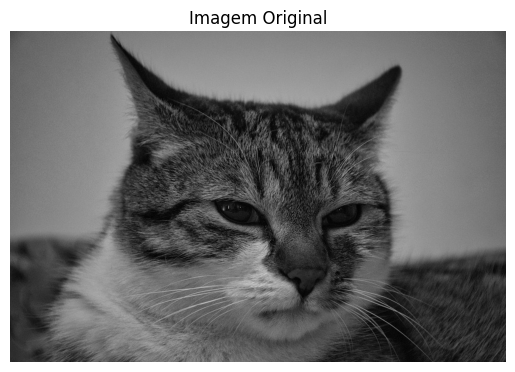

In [23]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Função para carregar a imagem local
def load_image_from_local(path):
    img = Image.open(path)  # Carrega a imagem a partir do arquivo local
    return img

# Caminho da imagem local
image_path = "gato_grayscale.jpg"

# Carregar a imagem
img = load_image_from_local(image_path)

# Exibir a imagem original
plt.imshow(img, cmap='gray')
plt.title("Imagem Original")
plt.axis("off")  # Desliga os eixos
plt.show()

# Converter a imagem para um array numpy
img_data = np.array(img)


Utilizamos o pacote requests para baixar o conteúdo da URL. Com o conteúdo baixado, usamos BytesIO para tratá-lo como um arquivo binário e carregá-lo com a função Image.open() do PIL. A imagem é então convertida para um array numpy para facilitar o processamento.

## Célula 2: Implementar a Compressão LZW
Agora vamos implementar o algoritmo de compressão LZW, que será aplicado após o QOI para uma compressão adicional.

In [33]:
# Função LZW para compressão
def lzw_compress(data):
    dictionary = {chr(i): i for i in range(256)}  # Inicializa o dicionário com caracteres ASCII
    next_code = 256
    current_string = ""
    compressed_data = []

    for byte in data:
        current_string += chr(byte)  # Adiciona o byte à string atual
        if current_string not in dictionary:
            if current_string[:-1]:  # Verificar se a string não está vazia
                compressed_data.append(dictionary[current_string[:-1]])  # Adiciona o código da string anterior
            # Adiciona a nova string ao dicionário
            dictionary[current_string] = next_code
            next_code += 1
            current_string = chr(byte)  # Reinicia a string com o byte atual

    # Adiciona a última sequência
    if current_string:
        compressed_data.append(dictionary[current_string])

    return compressed_data

# Função para salvar os dados comprimidos em um arquivo
def save_compressed_data(filename, compressed_data):
    with open(filename, 'wb') as f:
        np.save(f, np.array(compressed_data, dtype=np.uint32))  # Salva os dados comprimidos em formato binário

# Testando a compressão LZW com os dados da imagem
img_flat = img_data.flatten()  # Achata a imagem para 1D
lzw_compressed_data = lzw_compress(img_flat)

# Salvar os dados comprimidos
lzw_compressed_filename = "lzw_compressed.npy"
save_compressed_data(lzw_compressed_filename, lzw_compressed_data)

# Exibir tamanhos
original_size = len(img_flat)
compressed_size = len(lzw_compressed_data)

print(f"Tamanho original da imagem: {original_size} bytes")
print(f"Tamanho comprimido (LZW): {compressed_size} bytes")


Tamanho original da imagem: 1843200 bytes
Tamanho comprimido (LZW): 313290 bytes


A função lzw_compress realiza a compressão da imagem convertida para um vetor unidimensional. A comparação entre os tamanhos original e comprimido nos ajuda a observar a eficiência da compressão.

## Célula 3: Implementar a Compressão QOI
Agora vamos aplicar o algoritmo QOI, que é uma compressão de imagem sem perdas simples e eficiente.

In [34]:
# Função QOI para compressão de imagens
def qoi_compress(img_data):
    img_data = img_data.reshape(-1, 3)  # Supondo que a imagem seja RGB

    compressed_data = []
    prev_pixel = None
    run_length = 0

    for pixel in img_data:
        if prev_pixel is not None and np.array_equal(prev_pixel, pixel) and run_length < 62:
            run_length += 1
        else:
            if prev_pixel is not None:
                if run_length > 0:
                    compressed_data.append((0b10, run_length, prev_pixel))
                else:
                    compressed_data.append((0b00, prev_pixel))
            run_length = 0
        prev_pixel = pixel

    if prev_pixel is not None:
        if run_length > 0:
            compressed_data.append((0b10, run_length, prev_pixel))
        else:
            compressed_data.append((0b00, prev_pixel))

    return compressed_data

# Função para salvar os dados comprimidos em um arquivo (QOI)
def save_qoi_compressed_data(filename, compressed_data):
    with open(filename, 'wb') as f:
        np.save(f, np.array(compressed_data, dtype=object))  # Salva como binário

# Testando a compressão QOI com a imagem
qoi_compressed_data = qoi_compress(img_data)

# Salvar os dados comprimidos
qoi_compressed_filename = "qoi_compressed.npy"
save_qoi_compressed_data(qoi_compressed_filename, qoi_compressed_data)

# Exibir tamanhos
qoi_compressed_size = len(qoi_compressed_data)

print(f"Tamanho comprimido (QOI): {qoi_compressed_size} bytes")


Tamanho comprimido (QOI): 557097 bytes


A compressão QOI é aplicada sobre a imagem para verificar a redução de tamanho. O algoritmo tenta reduzir a quantidade de dados repetitivos ao armazenar apenas um valor repetido com a quantidade de repetições.

## Célula 4: Descompressão LZW
Agora vamos implementar o algoritmo de compressão LZW, que será aplicado após o QOI para uma compressão adicional.

In [35]:
# Função de descompressão LZW
def lzw_decompress(compressed_data):
    dictionary = {i: chr(i) for i in range(256)}
    next_code = 256
    current_code = compressed_data[0]
    decompressed_data = [dictionary[current_code]]

    for code in compressed_data[1:]:
        if code in dictionary:
            entry = dictionary[code]
        elif code == next_code:
            entry = dictionary[current_code] + dictionary[current_code][0]
        else:
            raise ValueError("Código não encontrado no dicionário")

        decompressed_data.append(entry)
        dictionary[next_code] = dictionary[current_code] + entry[0]
        next_code += 1
        current_code = code

    return np.array([ord(c) for entry in decompressed_data for c in entry], dtype=np.uint8)

# Função para carregar os dados comprimidos LZW de um arquivo
def load_compressed_data(filename):
    with open(filename, 'rb') as f:
        return np.load(f)  # Carrega os dados comprimidos

# Carregar os dados comprimidos LZW
loaded_lzw_compressed_data = load_compressed_data(lzw_compressed_filename)

# Descomprimir os dados LZW
lzw_decompressed_array = lzw_decompress(loaded_lzw_compressed_data)

# Mostrar PSNR
psnr_lzw = psnr(img_flat, lzw_decompressed_array)
print(f"PSNR após descompressão LZW: {psnr_lzw:.2f} dB")


MSE: 0.0
PSNR após descompressão LZW: inf dB


A função lzw_decompress converte os dados comprimidos de volta ao formato original. Ela utiliza um dicionário para mapear os códigos para strings originais.

## Célula 5: Descompressão QOI
Agora, vamos descomprimir os dados utilizando o QOI.

In [36]:
# Função de descompressão QOI
def qoi_decompress(compressed_data, width, height):
    decompressed_data = []
    for entry in compressed_data:
        if entry[0] == 0b10:
            decompressed_data.extend([entry[2]] * (entry[1] + 1))
        else:
            decompressed_data.append(entry[1])

    decompressed_data = np.array(decompressed_data, dtype=np.uint8)
    decompressed_data = decompressed_data.reshape(height, width, 3)
    return decompressed_data

# Função para carregar os dados comprimidos QOI de um arquivo
def load_qoi_compressed_data(filename):
    with open(filename, 'rb') as f:
        return np.load(f, allow_pickle=True)  # Carrega os dados comprimidos

# Carregar os dados comprimidos QOI
loaded_qoi_compressed_data = load_qoi_compressed_data(qoi_compressed_filename)

# Descomprimir os dados QOI (aqui usamos o tamanho da imagem original)
qoi_decompressed_data = qoi_decompress(loaded_qoi_compressed_data, img_data.shape[1], img_data.shape[0])

# Mostrar PSNR
psnr_qoi = psnr(img_flat, qoi_decompressed_data.flatten())
print(f"PSNR após descompressão QOI: {psnr_qoi:.2f} dB")


MSE: 0.0
PSNR após descompressão QOI: inf dB


A função qoi_decompress reconstrói os dados comprimidos de volta à sua forma original. Após a descompressão, a imagem é reconstruída e exibida.

## Célula 6: Visualização de Resultados e Comparação
Aqui comparamos as imagens original, comprimida e descomprimida para observar a qualidade da compressão e as métricas de desempenho como PSNR.

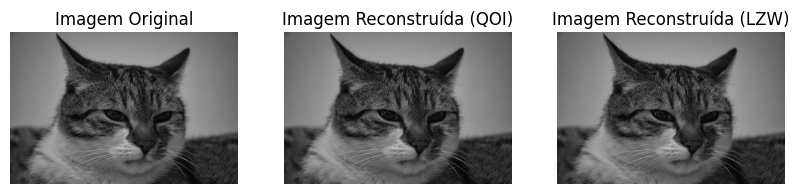

In [37]:
# Comparar as imagens
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Imagem Original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(qoi_decompressed_data)
plt.title("Imagem Reconstruída (QOI)")
plt.axis("off")

lzw_reconstructed_image = Image.fromarray(lzw_decompressed_array.reshape(img_data.shape).astype(np.uint8))
plt.subplot(1, 3, 3)
plt.imshow(lzw_reconstructed_image)
plt.title("Imagem Reconstruída (LZW)")
plt.axis("off")

plt.show()


Aqui, comparamos a qualidade da imagem reconstruída para ambas as compressões (LZW e QOI) usando o PSNR. Além disso, exibimos as imagens reconstruídas para análise visual.